## Coastline Changes

By Jon, Damian and Martyna

## Instructions

First create an Anaconda environment and install geemap:

conda create -n gee python

conda activate gee

conda install mamba -c conda-forge

mamba install geemap -c conda-forge


In [1]:
import os
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import re
import cv2
import easygui
import time

### Displays images from an array
This method provides a central point of displaying an array of images

In [2]:
def displayImages(imageArray, titleArray, rows, columns):
    if rows > 9 or columns > 9 or len(imageArray) > 9 or len(imageArray) != len(titleArray):
        return
    
    fig = plt.figure(num=None, figsize=(20, 80), dpi=80, facecolor='w', edgecolor='k')
    plt.rc('font', size=10)

    for i in range(len(imageArray)):
        place = str(rows) + str(columns) + str(i + 1)
        place = int(place)
        
        fig.add_subplot(place)
        plt.title(titleArray[i])
        plt.set_cmap('gray')
        plt.imshow(imageArray[i]);
        

### Crops full size images of the satelite imagery to a desired size

In [3]:
def cropImageFromCentre(img, crop_w, crop_h):
    h, w, d = img.shape

    cropSizeFromCentre = (crop_w, crop_h)
    x = int(w/2)
    y = int(h/2)
    pt1 = (x - int(crop_w/2), y - int(crop_h/2))
    pt2 = (x + int(crop_w/2), y + int(crop_h/2))

    croppedImage = img[pt1[1] : pt2[1], pt1[0] : pt2[0]]

    return croppedImage

### Crops images from a selected file.
This method is no longer used as everything is done automatically now.<br>
However, it still a method that may be used in the future.<br>
This method crops the image from the centerpoint<br>

In [4]:
# Crop the region from a full screenshot (Manual Cropping)
def manualCropping():
    # Pick image
    easygui.msgbox("Pick the image you want to crop")
    imageFilePath = easygui.fileopenbox(filetypes=["*.jpg","*.jpeg","*.png"])

    I = cv2.imread(imageFilePath)
    h, w, d = I.shape
    
    cropSizeFromCentre = (600, 600)
    x = int(w/2)
    y = int(h/2)
    pt1 = (x - int(cropSizeFromCentre[0]/2), y - int(cropSizeFromCentre[1]/2))
    pt2 = (x + int(cropSizeFromCentre[0]/2), y + int(cropSizeFromCentre[1]/2))

    croppedImage = I[pt1[1] : pt2[1], pt1[0] : pt2[0]]

    # Write image to a file
    # The image file name is extracted from its full path
    imageFileName = re.search("([^\\\]*$)", imageFilePath).group(0)
    if imageFileName == None:
        imageFileName = "CroppedImage.png"
    
    # The new image name will have "Cropped" in front of it
    newFileName = "Cropped"+imageFileName
    cv2.imwrite(newFileName, croppedImage)

    plt.imshow(cv2.cvtColor(croppedImage, cv2.COLOR_BGR2RGB))

### A central point of access for creating a map
The longitude and latitude can be passed to center the map<br>
The zoom is how zoomed in the map is going to be on the location<br>

In [5]:
def generateMap(longitude, latitude, zoom):
    global regionOfInterestPoint
    if zoom == None:
        zoom = 11
        
    if longitude == None or latitude == None:
        Map = geemap.Map(center=(44.5779, -1.2319), zoom=zoom)
        regionOfInterestPoint = ee.Geometry.Point(-1.2319, 44.5779)
    else:
        Map = geemap.Map(center=(latitude, longitude), zoom=zoom)
        regionOfInterestPoint = ee.Geometry.Point(longitude, latitude)
        
    return Map

In [6]:
Map = generateMap(None, None, None)
Map

Map(center=[44.5779, -1.2319], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButto…

### Centers map on the last marker drawn
The latitude and longitude of the last marker drawn on the map is extracted and the map is centered<br> to that coordinate in preperation for the image capture of the map.

In [7]:
# Gets the last drawn feature (E.g. Point)
def getLastDrawnPoint():
    feature = Map.draw_last_feature
    zoom = 11
    if feature != None:
        # Extract coordinates
        featureInfo = feature.getInfo()
        featureType = featureInfo.get("geometry").get("type")
        featureCoords = featureInfo.get("geometry").get("coordinates")
        featureCoords = {"longitude" : float(featureCoords[0]), "latitude" : float(featureCoords[1])}

        print(featureCoords)
    
        return featureCoords
    
    else:
        return None

In [8]:
def getBandImagesFromSatellite(imageCollectionID, regionOfInterestPoint, startDate, endDate):
    # Get image collection
    landsatCollection = ee.ImageCollection(imageCollectionID)
    # Filter by region
    areaOfInterest = landsatCollection.filterBounds(regionOfInterestPoint)
    # Filter by date
    landsat = landsatCollection.filterDate(startDate, endDate)
    # Least cloudly image from the collection is chosen
    leastCloudyImage = ee.Image(areaOfInterest.sort('CLOUD_COVER').first())

    print('Total number:', areaOfInterest.size().getInfo())
    print(leastCloudyImage.get('CLOUD_COVER').getInfo())

    landsatBandImages = []
    titleArray = []
    for i in range(7):
        band = 'B' + str(i + 1)

        # Band 6 on landsat 5 returns an entirely white image. This outlier is skipped entirely.
        if band == 'B6' and imageCollectionID == 'LANDSAT/LT05/C01/T1_SR':
            continue;

        visualParams = {
            'min': 0,
            'max': 5000,
            'bands': [band]
        }
        Map.addLayer(leastCloudyImage, visualParams)

        time.sleep(5)
        # Temporairly save image using the Geemap method
        Map.to_image(outfile=os.getcwd() + "\\" + "BandImg.png", monitor=1)
        # Read the image in
        img = cv2.imread("BandImg.png")
        # Crop image
        croppedImg = cropImageFromCentre(img, 600, 600)
        # Store image in array
        landsatBandImages.append(croppedImg)
        # Store band image title in array
        titleArray.append(band)
    
    return landsatBandImages, titleArray

# Main get landsat images

In [9]:
# Landsat 5 collecton surface reflection (March 1984 - May 2012)
# LANDSAT/LT05/C01/T1_SR
    
# Landsat 8 collection surface reflection(April 2013 - Present)
# LANDSAT/LC08/C01/T1_SR

# Image collection names are initalized here, each collection corresponds to a satellite
# Each satelite has been taking images at a certain time frame
collections = {
    'landsat5': 'LANDSAT/LT05/C01/T1_SR',
    'landsat8': 'LANDSAT/LC08/C01/T1_SR'}

# Center map around last drawn point
lastDrawnPoint = getLastDrawnPoint()
if lastDrawnPoint != None:
    zoom = 11
    Map.setCenter(lastDrawnPoint["longitude"], lastDrawnPoint["latitude"], zoom)

easygui.msgbox("Please go into map fullscreen and wait until further notice")
time.sleep(5)

# Select collection
imageCollectionID = collections['landsat5']
startDate = '1990-01-01'
endDate = '1990-12-31'
landsat5_BandImages, landsat5_BandNames = getBandImagesFromSatellite(imageCollectionID, regionOfInterestPoint, startDate, endDate)

# Select collection
imageCollectionID = collections['landsat8']
startDate = '2018-01-01'
endDate = '2018-12-31'
landsat8_BandImages, landsat8_BandNames = getBandImagesFromSatellite(imageCollectionID, regionOfInterestPoint, startDate, endDate)


print("finished")
easygui.msgbox("Finished, Please exit fullscreen")

Total number: 343
0
Total number: 215
0
finished


'OK'

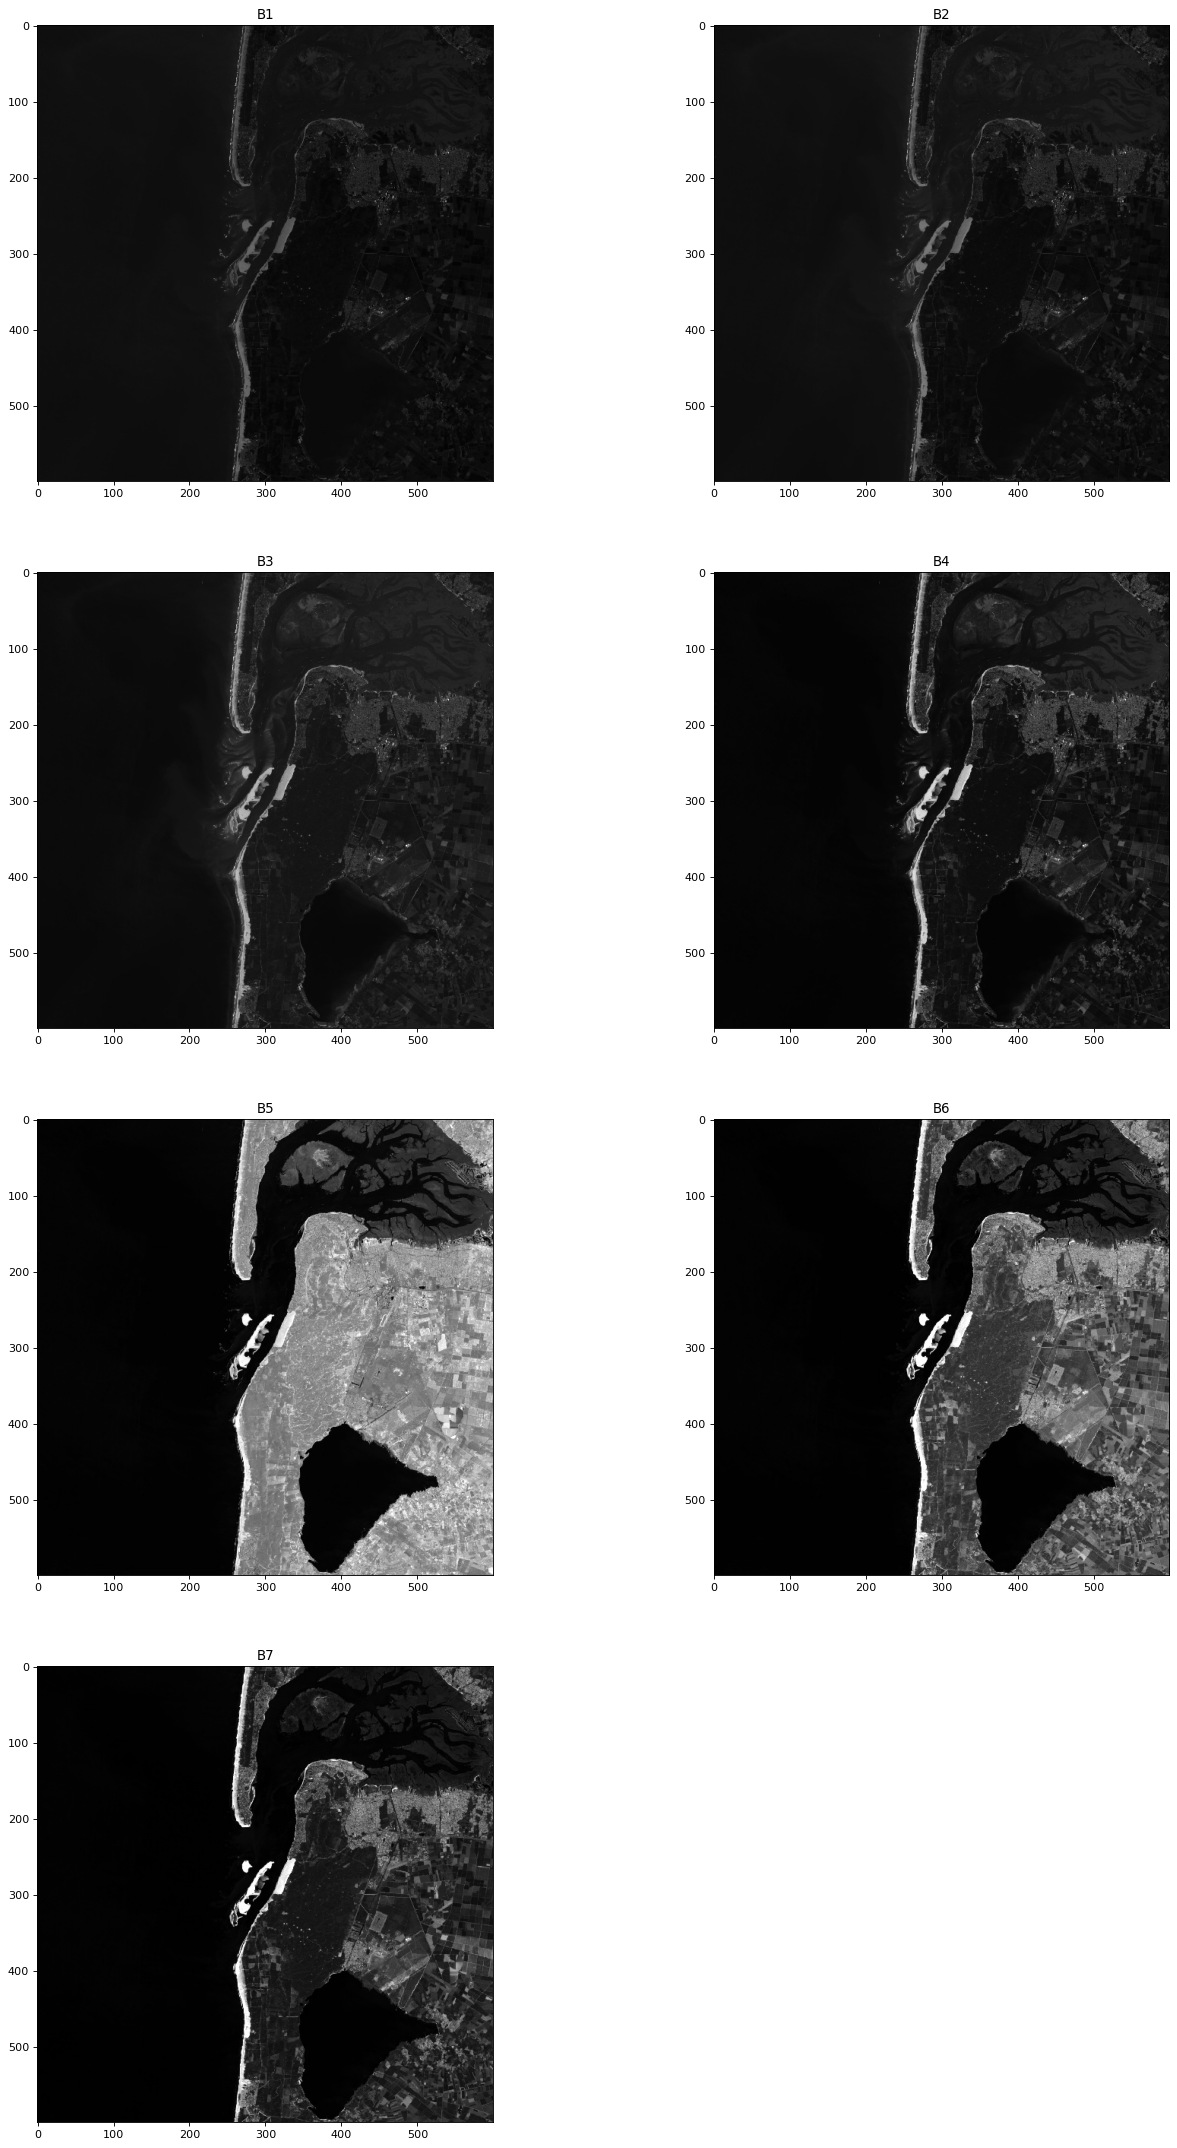

In [10]:
# Display Band Images
# displayImages(landsat5_BandImages, landsat5_BandNames, 9, 2)
displayImages(landsat8_BandImages, landsat8_BandNames, 9, 2)

In [11]:
def getKmeansImages(images):
    kmeansImages = []
    
    # Perform K-Means on each of the images
    for index in range(len(images)):
        img = images[index]

        # Image pixel array is reshaped into a 1D array (similar to ravel method)
        Z = img.reshape((-1,3))
        Z = np.float32(Z)

        # Perform K-Means
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 2
        ret,label,center=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Now convert back into uint8, and make original image
        center = np.uint8(center)
        res = center[label.flatten()]
        res2 = res.reshape((img.shape))

        kmeansImages.append(res2)
    
    return kmeansImages

In [12]:
def getBinaryCombinedImage(imageArray):
    binaryImages = []
    height, width, depth = imageArray[0].shape 

    # Create an empty black image with numpy.zeros
    combinedImage = np.zeros((height,width), np.uint8)
    # Combining with bitwise_or()
    for img in kmeansImages:
        # Convert images to binary images
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        (thresh, img_binary) = cv2.threshold(img_gray, 50, 255, cv2.THRESH_BINARY)

        # Combine the previously combined image with the new binary image
        combinedImage = cv2.bitwise_or(combinedImage, img_binary)

        # Store images in array
        binaryImages.append(img_binary)
    
    return combinedImage, binaryImages

### Perform K-Means on images, convert to binary and combine

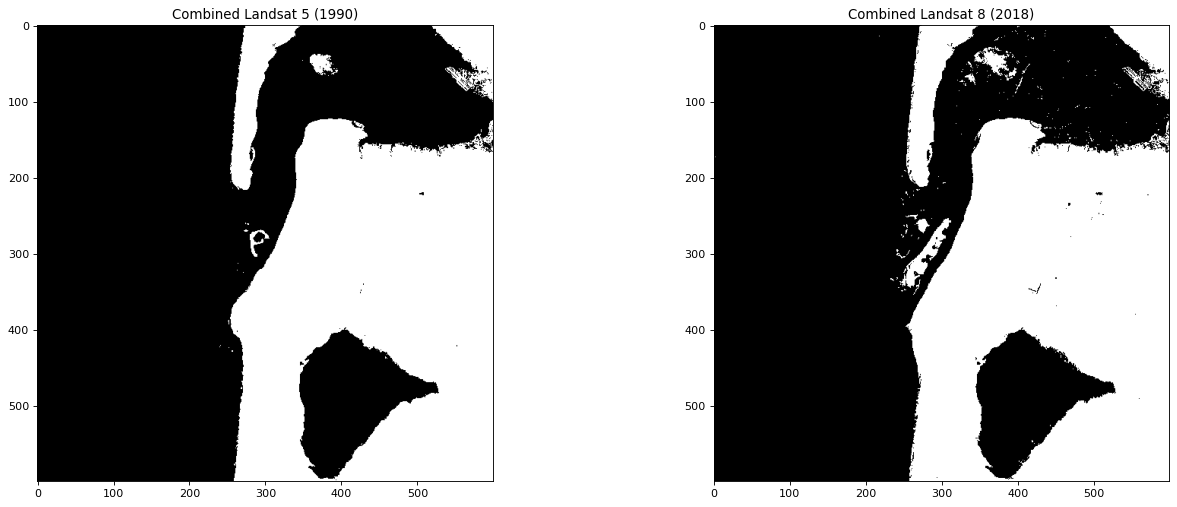

In [13]:
combinedImages = []
combinedImageTitles = []

# --------------------------------------------------------------------------------------------------------------------

kmeansImages = getKmeansImages(landsat5_BandImages.copy())
combinedImage, binaryImages = getBinaryCombinedImage(kmeansImages)

combinedImageTitles.append("Combined Landsat 5 (1990)")
combinedImages.append(combinedImage)

# Display K-Means Images
# displayImages(kmeansImages, landsat5_BandNames, 9, 2)

# Display K-Means Images in binary
# displayImages(binaryImages, landsat5_BandNames, 9, 2)

# --------------------------------------------------------------------------------------------------------------------

kmeansImages = getKmeansImages(landsat8_BandImages.copy())
combinedImage, binaryImages = getBinaryCombinedImage(kmeansImages)

combinedImageTitles.append("Combined Landsat 8 (2018)")
combinedImages.append(combinedImage)

# Display K-Means Images
# displayImages(kmeansImages, landsat8_BandNames, 9, 2)

# Display K-Means Images in binary
# displayImages(binaryImages, landsat8_BandNames, 9, 2)

# --------------------------------------------------------------------------------------------------------------------

displayImages(combinedImages, combinedImageTitles, 9, 2)
